In [1]:
import pandas as pd
import numpy as np
import os
from tqdm.auto import tqdm
from datetime import datetime
import collections

In [2]:
import matplotlib.pyplot as plt
from pylab import rcParams

In [3]:
from wordcloud import WordCloud
from PIL import Image

In [4]:
import plotly.graph_objects as go
import plotly.express as px

In [5]:
import seaborn as sns

In [6]:
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer

In [7]:
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf

In [8]:
# Reading dataset with base data for the list of app Ids
df_appId = pd.read_csv('Dataset//app_data_processed.csv', usecols=['appId','reviews'])

In [9]:
# For easier statistical plotting we need to consolidate the data and simplify in order to optimize memory allocation
# Date fields are shorten, appId is replaced with dataframe index 

http://localhost:8888/notebooks/Desktop/Thesis/09.1_Reviews_to_File_(Score).ipynb

In [10]:
# Result is stored in :
#      Dataset/app_all_review_scores.pkl
# Let's load it
df_score = pd.read_pickle('Dataset//app_all_review_scores.pkl')
df_score

id         at  repliedAt  score  thumbsUpCount
0               0 2020-07-30        NaT      3              6
1               0 2020-07-22        NaT      1              0
2               0 2020-07-11        NaT      4              0
3               0 2020-07-09        NaT      4              2
4               0 2020-07-02        NaT      1              0
...           ...        ...        ...    ...            ...
449840494  109922 2017-04-26 2017-04-26      5              3
449840495  109922 2017-04-22 2017-04-23      5              6
449840496  109922 2017-04-20 2017-04-21      5              0
449840497  109922 2017-04-03 2017-04-03      5              2
449840498  109922 2017-03-25 2017-03-26      5              3

[449840499 rows x 5 columns]

In [11]:
# Let's see what was the average appstore rating on a time series, groupped by month
per = df_score['at'].dt.to_period("M")
g = df_score['score'].groupby(per)

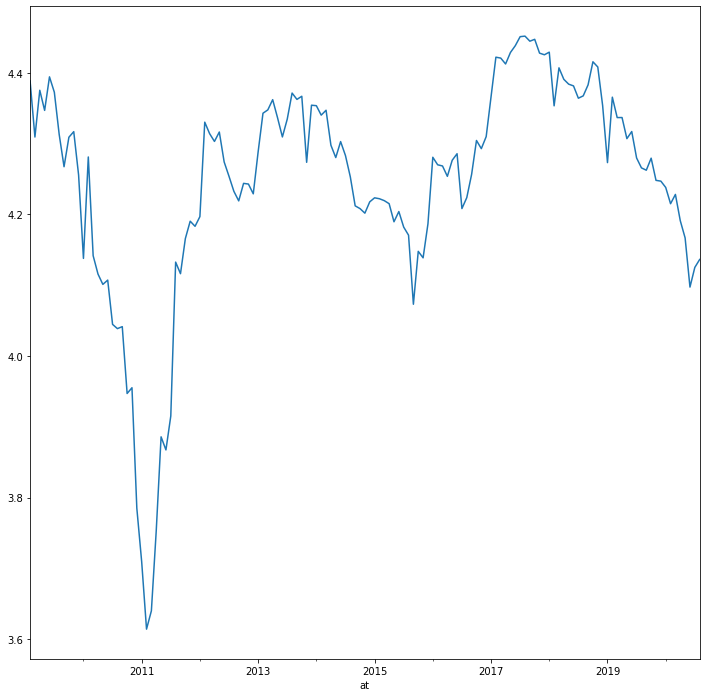

In [12]:
rcParams['figure.figsize'] = 12,12
g.mean().plot()

In [13]:
# We see that average rating that users have given to apps varied quite significantly 
# from the beginning of Google Play Store history. 
# Minimum average rating falls into 2011, which is probably related not the the quality of apps, 
# but rather new android system relaesed this year (3.0 Honeycomb) and introduction of android tablets. 
# Currently we see gradual decrease in ratings since 2017.

In [14]:
# Let's see how many thumbs up are getting reviews with certain stars
g = df_score.groupby('score')['thumbsUpCount'].agg(sum)

In [15]:
df = pd.DataFrame(g).reset_index().sort_values(by='score')

In [16]:
fig = px.pie(df, values='thumbsUpCount', names='score')
fig.update_layout(
    title={
        'text': "Thumbs Up for star rating, average",
        'xanchor': 'center',
        'y':0.95,
        'x':0.5,
        'yanchor': 'top',
        'font':{'size':25}
    },
    legend_title="Stars"    
)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

In [17]:
# We ca see that users prefer to give some reviews 'thumbs up' either if it is most positive or most negative.
# More than 2/3 of all 'thumbs up' are given for such extreme scores.


In [18]:
# Let's make a new field - Thumbs Up Score
df_score['thumbsUpScore'] = df_score['thumbsUpCount'] * df_score['score']

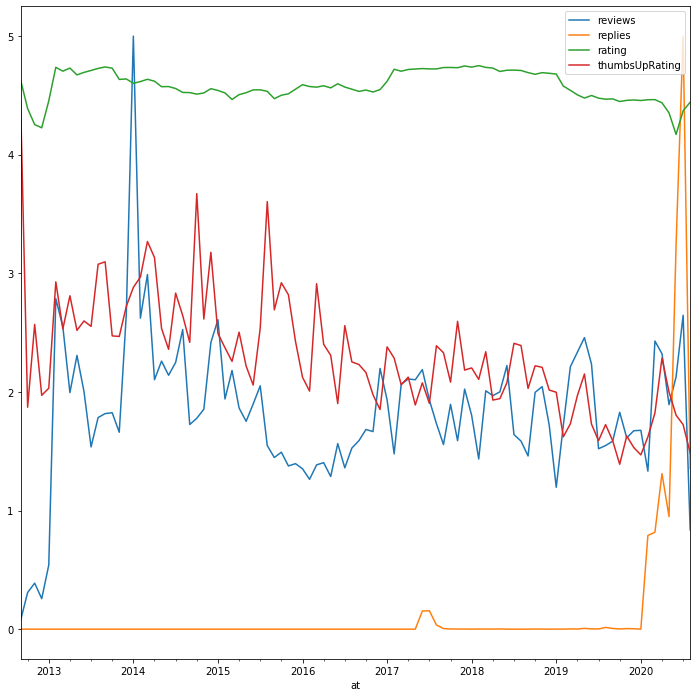

In [19]:
# let's take as example, some app with lot's of reviews (fifth biggest)
# And see how some aggregated values look like when groupped per month
def Get_App_Score_df(df):
    per = df['at'].dt.to_period("M")
    app_score = df.groupby(per).agg(reviews=('id','count'),
                             replies=('repliedAt','count'),
                             rating=('score','mean'),
                             thumbsUpScore=('thumbsUpScore','sum'),
                             thumbsUpCount=('thumbsUpCount','sum'))
    app_score['thumbsUpRating'] = app_score['thumbsUpScore']/app_score['thumbsUpCount']
    app_score['thumbsUpRating'].replace(np.inf,np.nan,inplace=True)
    app_score['thumbsUpRating'].replace(-np.inf,np.nan,inplace=True)
    app_score['thumbsUpRating'] = app_score['thumbsUpRating'].fillna(np.mean(app_score['thumbsUpRating']))
    app_score = app_score[['reviews','replies','rating','thumbsUpRating']]
    return app_score


app_score = Get_App_Score_df(df_score[df_score.id == df_score.id.value_counts().index[4]])
app_score['reviews'] = app_score['reviews'] * 5 / app_score['reviews'].max()
app_score['replies'] = app_score['replies'] * 5 / app_score['replies'].max()
app_score.plot()

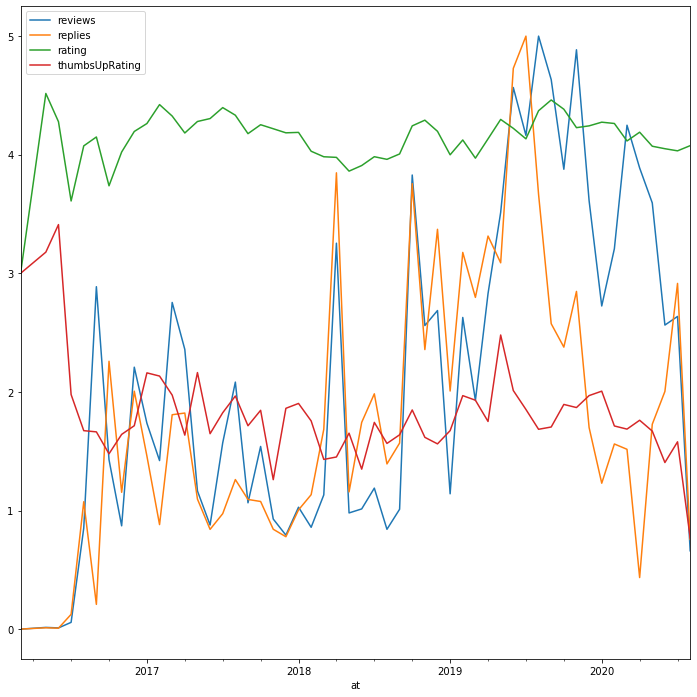

In [20]:
# We see that developers have started actually replying on customer criticism
# only when thumbsUpRating has dropped below 3. Hopefully that will help them
# Let's see another app, the next one (eigth in most reviews)
app_score = Get_App_Score_df(df_score[df_score.id == df_score.id.value_counts().index[7]])
app_score['reviews'] = app_score['reviews'] * 5 / app_score['reviews'].max()
app_score['replies'] = app_score['replies'] * 5 / app_score['replies'].max()
app_score.plot()

In [21]:
# Here we can see a different picture - developer is very active from the very beginning
# Let's see how it reflecs on a popularity trend

In [22]:
# Now, let's do some linear regression for the aggregates values
# What is the trend for rating, reviews and thumbUpRating ?
# Is it going up or down? Is app getting better over time or becoming less popular?
def Get_LR_coef(X, y,to_print=True):
    lr = LinearRegression()
    try:
        lr.fit(X, y)
    except:
        lr.fit(X, y)
        
    if to_print:
        print("For {}: Intercept {}, Regresion coefficient {}".\
              format(y.name,np.round(lr.intercept_,2), np.round(lr.coef_[0],6)))
    else:
        return lr
    
app_score = Get_App_Score_df(df_score[df_score.id == df_score.id.value_counts().index[4]])
X = app_score.reset_index()['at'].dt.to_timestamp().map(datetime.toordinal).to_frame(name='at')
print("For the first app")
Get_LR_coef(X, app_score['thumbsUpRating'])
Get_LR_coef(X, app_score['reviews'])
Get_LR_coef(X, app_score['rating'])

app_score = Get_App_Score_df(df_score[df_score.id == df_score.id.value_counts().index[7]])
X = app_score.reset_index()['at'].dt.to_timestamp().map(datetime.toordinal).to_frame(name='at')
print("For the second app")
Get_LR_coef(X, app_score['thumbsUpRating'])
Get_LR_coef(X, app_score['reviews'])
Get_LR_coef(X, app_score['rating'])


For the first app
For thumbsUpRating: Intercept 308.56, Regresion coefficient -0.000416
For reviews: Intercept -288613.09, Regresion coefficient 0.444727
For rating: Intercept 18.72, Regresion coefficient -1.9e-05
For the second app
For thumbsUpRating: Intercept 271.48, Regresion coefficient -0.000366
For reviews: Intercept -31895678.77, Regresion coefficient 43.351834
For rating: Intercept -63.65, Regresion coefficient 9.2e-05


In [23]:
# Positive Regression coefficient tells us that trend is going up. 
# We can see that the second app is doing slightly better:
#    most of the its trends are either positive or better than for the first app

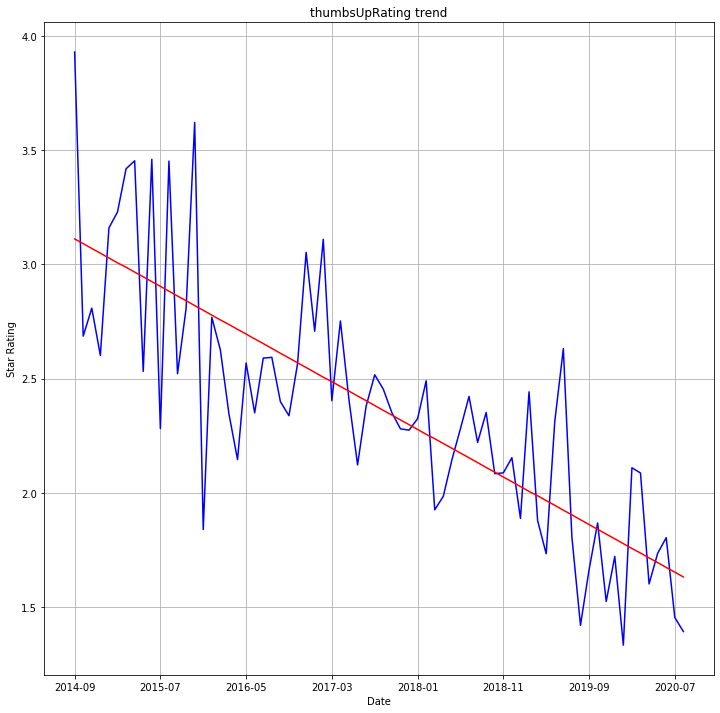

In [24]:
# Let's plot some values with trend line
# We'll take our first app and check its thumbsUpRating
app_score = Get_App_Score_df(df_score[df_score.id == df_score.id.value_counts().index[2]])
X = app_score.reset_index()['at'].dt.to_timestamp().map(datetime.toordinal).to_frame(name='at')
y = app_score['thumbsUpRating']
lr = Get_LR_coef(X, y, False)
y_pred = lr.predict(X)

fig, ax = plt.subplots()
x = np.arange(0,len(X),1)
ax.plot(x, y, color='blue')
ax.plot(x, y_pred, color='red')

ax.set(ylabel='Star Rating', xlabel='Date', title='{} trend'.format(y.name))
ax.grid()

def return_date(i):
    try:
        return app_score.reset_index()['at'][int(i)]
    except:
        return ''
    
# Trick to show proper axes    
fig.canvas.draw()
ax.set_xticklabels([return_date(item.get_text()) for item in ax.get_xticklabels()])

plt.show()


In [25]:
# So that trend line gives us the impression on the timeline features progress. 
# Let's measure it for the rest of the apps

In [26]:
# Running through the list of appIds and making two datasets
# First - with groupped by month values of 
# - Total number of reviews
# - Number of developer replies
# - Average rating
# - Average rating derived from thumbsUp count and rating that was marked with thumb up
# Second - with linear regression coefficients for the 
# 'reviews','rating' and 'thumbsUpRating'
# Saving each into a separate csv file 
# The followinng notebook was made for this. We will use multi-thread to speed up the calculations

http://localhost:8888/notebooks/Desktop/Thesis/09.2_Reviews_Monthly_Stats.ipynb

In [27]:
# Result is stored in :
#      Dataset/app_score_monthly.csv
#      Dataset/app_score_trends.csv
df_monthly_avg = pd.read_csv('Dataset//app_score_monthly.csv')
df_monthly_avg

id       at  reviews  replies    rating  thumbsUpRating
0             4  2011-10        1        0  5.000000        5.000000
1             4  2011-11        1        0  5.000000        5.000000
2             4  2012-06        1        0  5.000000        5.000000
3             4  2012-08        1        0  5.000000        5.000000
4             4  2013-01        1        1  1.000000        1.000000
...         ...      ...      ...      ...       ...             ...
2946241  109921  2020-04        8        0  3.375000       -3.800000
2946242  109921  2020-05        5        0  3.000000        3.090909
2946243  109921  2020-06        5        0  4.000000        5.000000
2946244  109921  2020-07        5        0  4.000000        2.362308
2946245  109921  2020-08        3        0  2.666667        2.362308

[2946246 rows x 6 columns]

In [28]:
df_trends = pd.read_csv('Dataset//app_score_trends.csv')
df_trends

id  thumbsUpRating   reviews    rating
0           4       -0.000072  0.000206  0.000072
1          10       -0.000395 -0.003959  0.000154
2           2        0.000134 -0.000285 -0.000889
3           3       -0.000021  0.001499  0.000179
4           1       -0.000616 -0.006387 -0.000499
...       ...             ...       ...       ...
84568  109915        0.000024 -0.017242 -0.000004
84569  109917       -0.000299  0.000277 -0.000427
84570  109922       -0.000526 -0.000084  0.000050
84571  109918        0.000150 -0.002089  0.000124
84572  109921       -0.000432 -0.031887 -0.000044

[84573 rows x 4 columns]

In [29]:
# Before we do more visualizations, let's make some other features out of our data

In [30]:
# Now let's see what we can do with the actual reviews.
# Can we extract any insights from them?
# Let's see how many reviews we have altogether
df_all_reviews = pd.read_csv('Dataset//app_data_processed.csv', usecols=['reviews'])
df_all_reviews.sum()

reviews    1.570232e+09
dtype: float64

In [31]:
# It seems it will be very difficult to conduct any full-scale NLP analysis with so many apps and their reviews 
# So, in order to simplify, as a first step of NLP will be tokenization and lemmatization, keeping only 
# VERBS, NOUNS, ADJECTIVES and ADVERBS, as main holders of the review meaning, skipping all the rest.
# This way we will decrease the occupied space and speed up further processing

In [32]:
# First attempt of lemmatization was using NLTK library
# The process of lemmatization using NLTK library took about 2 minutes for 10000 reviews
# Total number of reviews that need to be processed is more than 1.5B, so 10K makes only 1/150'000 of the whole
# NLTK library is too slow. Let's try spacy

In [33]:
# After some more tests, it seems that Spacy, running on GPU makes it much faster - just 10 seconds, 
# but not enough for a feasible processing time - we will need to parallellize

In [34]:
# For the tokenization and lemmatization we will be using spacy library as it offers best performance, 
# altogether with using GPU 
# Result will be written in a separate folder, to keep original text reviews for whatever reason in future
# pyton 'threading' library is failing to make parallel calculations on GPU, 
# so we've switched to 'multiprocessing' library, with the only caveat that it doesn't work in jupyter


http://localhost:8888/edit/Desktop/Thesis/09.3_Reviews_Lemmatize.py

In [35]:
# Result is stored in:
#       'ReviewsLemma' folder
#        one file per app 
#        appId is the file name
#        file format - pickle
pd.read_pickle(''.join(['ReviewsLemma//',df_appId.loc[0]['appId'],'.pkl']))

at                                            content  \
0    2020-07-30 03:53:19  [year, app, good, last, update, problem, begin...   
1    2020-07-22 21:33:52                                       [work, time]   
2    2020-07-11 18:51:49  [use, put, simple, rule, mobile, dail, code, c...   
3    2020-07-09 10:09:33  [like, app, screen, brightness, can, pick, val...   
4    2020-07-02 20:24:32                                              [bad]   
...                  ...                                                ...   
2455 2011-02-09 04:50:38  [unbelievably, useful, finally, decent, reliab...   
2456 2011-02-08 20:02:31  [amazing, way, customize, function, phone, ple...   
2457 2011-02-06 19:58:47              [cancel, silent, mode, work, android]   
2458 2011-02-04 20:45:55                [excellent, program, simple, setup]   
2459 2011-02-04 19:00:47                    [nice, app, how, time, trigger]   

     repliedAt  score  thumbsUpCount  
0          NaT      3              6  
1          NaT      1              0  
2          NaT      4              0  
3          NaT      4              2  
4          NaT      1              0  
...        ...    ...            ...  
2455       NaT      5              2  
2456       NaT      5              2  
2457       NaT      3              0  
2458       NaT      5              2  
2459       NaT      4              1  

[2450 rows x 5 columns]

In [36]:
# Let's make sentiment analysys using TextBlob
# Two new features will be created - polarity and subjectivity 
# As in previous task, multiprocessing is the choice and we've moved to pycharm editor
# You may notice different approaches to multi-threading, mostly because with every next implementation 
# we've learned to apply it in a more effective way and just didn't polish all previous attempts 
# as they turned out also quite well.

http://localhost:8888/edit/Desktop/Thesis/09.4_Reviews_Sentiment_Analysis.py

In [37]:
# Results are stored in:
#       'ReviewsSentiment' folder
#        one file per app 
#        appId is the file name
#        file format - pickle
pd.read_pickle(''.join(['ReviewsSentiment//',df_appId.loc[0]['appId'],'.pkl']))

at                                            content  \
0    2020-07-30 03:53:19  [year, app, good, last, update, problem, begin...   
1    2020-07-22 21:33:52                                       [work, time]   
2    2020-07-11 18:51:49  [use, put, simple, rule, mobile, dail, code, c...   
3    2020-07-09 10:09:33  [like, app, screen, brightness, can, pick, val...   
4    2020-07-02 20:24:32                                              [bad]   
...                  ...                                                ...   
2455 2011-02-09 04:50:38  [unbelievably, useful, finally, decent, reliab...   
2456 2011-02-08 20:02:31  [amazing, way, customize, function, phone, ple...   
2457 2011-02-06 19:58:47              [cancel, silent, mode, work, android]   
2458 2011-02-04 20:45:55                [excellent, program, simple, setup]   
2459 2011-02-04 19:00:47                    [nice, app, how, time, trigger]   

     repliedAt  score  thumbsUpCount  polarity  subjectivity  
0          NaT      3              6  0.350000      0.333333  
1          NaT      1              0 -0.166667      0.166667  
2          NaT      4              0  0.107262      0.409524  
3          NaT      4              2  0.083333      0.450000  
4          NaT      1              0  0.000000      0.000000  
...        ...    ...            ...       ...           ...  
2455       NaT      5              2  0.155556      0.341270  
2456       NaT      5              2  0.466667      0.533333  
2457       NaT      3              0  0.000000      0.100000  
2458       NaT      5              2  0.500000      0.678571  
2459       NaT      4              1  0.600000      1.000000  

[2450 rows x 7 columns]

In [38]:
# For easier statistical plotting we need to consolidate the data and simplify in order to optimize memory allocation
# Date fields are shorten, appId is replaced with dataframe index 
# Running through the list of appIds and loading app review stats fields 
# Saving into a separate csv file as it allowes append writing, contrary to pickle

http://localhost:8888/notebooks/Desktop/Thesis/09.5_Reviews_to_File_(Stats).ipynb

In [39]:
# Result is saved in the following file:
df_stats = pd.read_pickle('Dataset//app_all_review_stats.pkl')
df_stats

id  origId         at  repliedAt  score  thumbsUpCount  \
0               0       0 2020-07-30        NaT      3              6   
1               0       1 2020-07-22        NaT      1              0   
2               0       2 2020-07-11        NaT      4              0   
3               0       3 2020-07-09        NaT      4              2   
4               0       4 2020-07-02        NaT      1              0   
...           ...     ...        ...        ...    ...            ...   
448167780  109922     228 2017-04-26 2017-04-26      5              3   
448167781  109922     229 2017-04-22 2017-04-23      5              6   
448167782  109922     230 2017-04-20 2017-04-21      5              0   
448167783  109922     231 2017-04-03 2017-04-03      5              2   
448167784  109922     232 2017-03-25 2017-03-26      5              3   

           polarity  subjectivity  reviewLength  
0          0.350000      0.333333            11  
1         -0.166667      0.166667             2  
2          0.107262      0.409524            35  
3          0.083333      0.450000            31  
4          0.000000      0.000000             1  
...             ...           ...           ...  
448167780  0.037500      0.708929            25  
448167781  0.466667      0.710119             9  
448167782  0.358333      0.558333             4  
448167783  1.000000      0.300000             3  
448167784  0.261667      0.718333            10  

[448167785 rows x 9 columns]

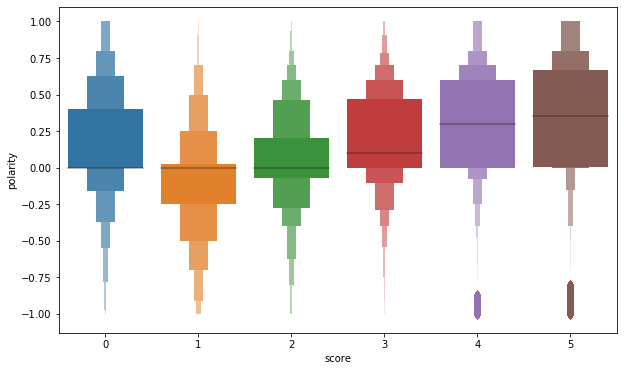

In [40]:
# Let's see the distribution of sentiment polarity values for different star ratings
plt.figure(figsize=(10,6))
sns.boxenplot(x='score', y='polarity', data=df_stats)
plt.show();

In [41]:
# We see that TextBlob did a decent job and there is a visible dependency 
# Higher star rating corresponds to a higher polarity of review, 
# however, 0 star rating has high sentiment polarity as well and that is strange
# Let's see why
# We will load some very high sentiment polarity review that is having score=0
df_stats[(df_stats.score==0)&(df_stats.polarity>0.95)]

id  origId         at repliedAt  score  thumbsUpCount  \
2589783       769  121273 2018-05-18       NaT      0              0   
7641502      2422    2480 2011-01-13       NaT      0              0   
8118023      2768    2557 2011-01-07       NaT      0              0   
8118263      2768    2797 2010-12-24       NaT      0              0   
8134428      2775    1919 2010-12-27       NaT      0              0   
...           ...     ...        ...       ...    ...            ...   
447681010  109818    8389 2011-02-12       NaT      0              1   
447725573  109898    1486 2011-03-25       NaT      0              0   
447725780  109898    1693 2011-02-05       NaT      0              0   
447729034  109899    1497 2011-01-16       NaT      0              0   
447735578  109902    3258 2011-02-03       NaT      0              0   

           polarity  subjectivity  reviewLength  
2589783    1.000000          1.00             1  
7641502    1.000000          1.00             4  
8118023    1.000000          1.00             2  
8118263    1.000000          1.00             4  
8134428    0.976562          0.60             2  
...             ...           ...           ...  
447681010  1.000000          1.00             4  
447725573  1.000000          1.00             1  
447725780  1.000000          1.00             6  
447729034  1.000000          0.75             4  
447735578  1.000000          1.00             1  

[1002 rows x 9 columns]

In [42]:
# Let's take the first one (id=769) and see from there
df_app = pd.read_pickle(''.join(['ReviewsSentiment//',df_appId.iloc[769][0],'.pkl']))
df_app[(df_app['score']==0)&(df_app.polarity>0.95)]

at    content repliedAt  score  thumbsUpCount  \
121273 2018-05-18 01:17:21  [awesome]       NaT      0              0   

        polarity  subjectivity  
121273       1.0           1.0

In [43]:
# It seems, the reviewer just didn't set the star rating! It supposed to be 5 looking at the word 'awesome' in their review
# Let's see few more 
df_app = pd.read_pickle(''.join(['ReviewsSentiment//',df_appId.iloc[2422][0],'.pkl']))
df_app[(df_app['score']==0)&(df_app.polarity>0.95)]

at                      content repliedAt  score  \
2480 2011-01-13 22:14:06  [awesome, app, show, would]       NaT      0   

      thumbsUpCount  polarity  subjectivity  
2480              0       1.0           1.0

In [44]:
df_app = pd.read_pickle(''.join(['ReviewsSentiment//',df_appId.iloc[2768][0],'.pkl']))
df_app[(df_app['score']==0)&(df_app.polarity>0.95)]

at                       content repliedAt  score  \
2557 2011-01-07 00:34:12                [omg, awesome]       NaT      0   
2797 2010-12-24 00:52:58  [would, awesome, keep, shut]       NaT      0   

      thumbsUpCount  polarity  subjectivity  
2557              0       1.0           1.0  
2797              0       1.0           1.0

In [45]:
# Same story here - people just got too excited to click the star rating!
# So, it seems we can fix that
# But first, let's see at the whole count of such zero-stars reviews
df_stats.groupby('score').size()

score
0        27871
1     44181355
2     12752002
3     24203091
4     54967115
5    312036351
dtype: int64

In [46]:
# It is by far the smallest group! Let's see how old are reviews there
df_stats[(df_stats['score']==0)].sort_values(by='at').tail()

id  origId         at repliedAt  score  thumbsUpCount  polarity  \
318553901  72329    5952 2018-07-31       NaT      0              0      0.00   
73265233   23631   20993 2018-08-01       NaT      0              0      0.05   
132140695  36345  155355 2018-08-01       NaT      0              0      0.80   
292581997  65557   46668 2018-08-01       NaT      0              0      0.70   
404087584  91993  216128 2018-08-01       NaT      0              0      0.30   

           subjectivity  reviewLength  
318553901          0.90             1  
73265233           0.50             2  
132140695          0.75             1  
292581997          0.60             2  
404087584          0.35             1

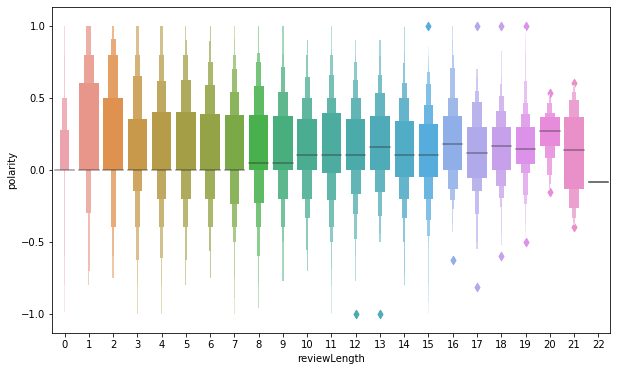

In [47]:
# Let's see the distribution of sentiment polarity values for different star ratings
plt.figure(figsize=(10,6))
sns.boxenplot(x='reviewLength', y='polarity', data=df_stats[(df_stats.score==0)])
plt.show();

In [48]:
# What is the correlation between them?
df_stats[(df_stats.score==0)][['reviewLength','polarity']].corr()

reviewLength  polarity
reviewLength      1.000000 -0.021223
polarity         -0.021223  1.000000

In [49]:
# It is clear that 0-stars was some temporary behaviour in the Play Market system and that is not possible 
# to enter 0 stars any more. Those with 0 stars have whole variety of polarity values, 
# so in order to properly set star rating, we need to perform supervised learning classification
# But as soon as that is not possible any more, such excersise is not practical. 
# So we can just drop them as not significant

In [50]:
# Before we drop it, let's explore yet another anomaly - when higly negative sentiment polarity 
# corresponds to a 5 star rating
# We will take a random sample of 10 such anomalies with not very long text (10 lemmas) and show thier original text
df_apps = pd.DataFrame()
for app_idn,orig_id in df_stats[(df_stats.score==5)&(df_stats.polarity<-0.95)&(df_stats.reviewLength==10)].sample(n=10, random_state=1)[['id','origId']].values:
    print(''.join(['ReviewsPKL//',df_appId.loc[app_idn].appId,'.pkl']))
    df_app = pd.read_pickle(''.join(['ReviewsPKL//',df_appId.loc[app_idn].appId,'.pkl']))
    df_apps = df_apps.append(df_app.loc[orig_id], ignore_index = True)
    
df_apps['content'].values

ReviewsPKL//com.quizup.core.pkl
ReviewsPKL//com.gameloft.android.ANMP.GloftA8HM.pkl
ReviewsPKL//com.teamlava.citystory.pkl
ReviewsPKL//com.hcg.cok.gp.pkl
ReviewsPKL//com.OCAS.ontariocolleges.pkl
ReviewsPKL//com.google.android.GoogleCamera.pkl
ReviewsPKL//com.drawapp.magicdoodle.pkl
ReviewsPKL//com.roblox.client.pkl
ReviewsPKL//com.lookout.pkl
ReviewsPKL//com.foursakenmedia.noblemen.pkl


array(['If your opponent gets disconnected, you get no experience. Should I be penalized because their phone or internet is terrible?',
       'The vote of multi-player is awful,  never could play infected or elimination',
       'It gets a bit boring after  a while as you just lose money but does not matter download now',
       "What happened to chat and Email??? Game restarts every time when chat or email is pressed!!! FIX IT PLEASE!!!!  CANNOT COLLECT ALLIANCE REWARDS IF EMAIL DOESN'T WORK!!!",
       "After playing with the terrible website I was hesitant to use the app but hey it was easier than the site and now I'm off to college!",
       "I hate Samsung bloat! Thank you!!!! Let's eradicate Samsung software together! Please add dual shot.",
       "Maybe she's just horrible So I'm not working tomorrow and then I got home an my house is on Cox",
       'Umm developer Roblox is being quitted people I no are saying its boring you have to do something about it or every one is going

In [51]:
# We can see that mony of those 5 stars are most likely a mistake! Reviews indeed look negative.
# Better to drop them as well from our further analysis
# Generalizing the outliers definition, we can drop the following items
df_stats[(df_stats.score>=4)&(df_stats.polarity<-0.75)]['id'].count()

542983

In [52]:
df_stats.drop(df_stats[(df_stats.score==0)|((df_stats.score>=4)&(df_stats.polarity<-0.75))].index, inplace=True)

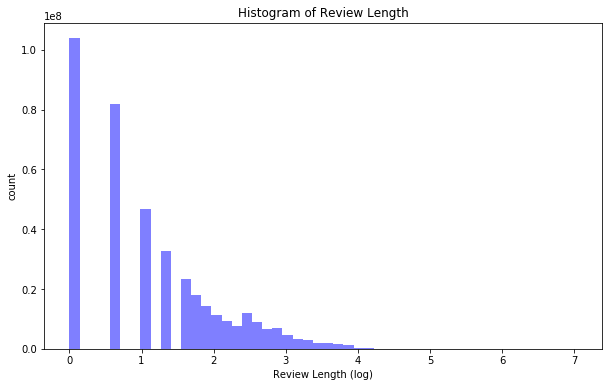

In [53]:
# What is the typical length of review?
num_bins = 50
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(np.log(df_stats[df_stats.reviewLength>0].reviewLength), num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Review Length (log)')
plt.ylabel('count')
plt.title('Histogram of Review Length')
plt.show();

In [54]:
# As we can see here, vast majority of reviews are 1-2 lemmas 

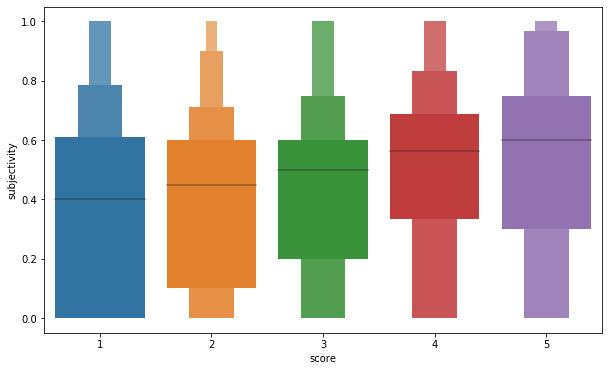

In [55]:
# Let's see the distribution of subjectivity values for different star ratings
plt.figure(figsize=(10,6))
sns.boxenplot(x='score', y='subjectivity', data=df_stats)
plt.show();

In [56]:
# Interestingly, subjectivity also increases with star rating.
# Looks like people express more emotions and personal opinion phrases when giving rather positive review

In [57]:
# It is imteresting to see if our new data added up some more correlations
corr = df_stats[['score','thumbsUpCount','subjectivity','polarity']].corr()

Text(0.5, 1, 'Features correlation matrix (corr>0.2)')

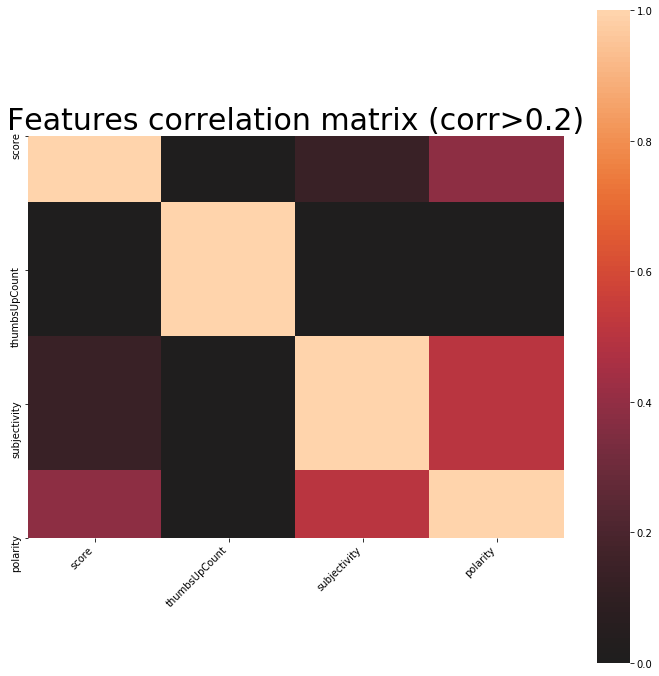

In [58]:
# Let's visualise our correlation matrix
ax = sns.heatmap(
    corr, 
    vmin=0, vmax=1, center=0, 
    #cmap=sns.diverging_palette(20, 220, n=10),
    square=True
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Features correlation matrix (corr>0.2)',size = 30)

In [59]:
# So there is little to no correlation between new features
# So, for example review's sentiment 'subjectivity' or 'polarity' seems do not have any effect on 'thumbsUpRating'
# Highest correlation here is between polarity and subjectivity, but we saw it before as well


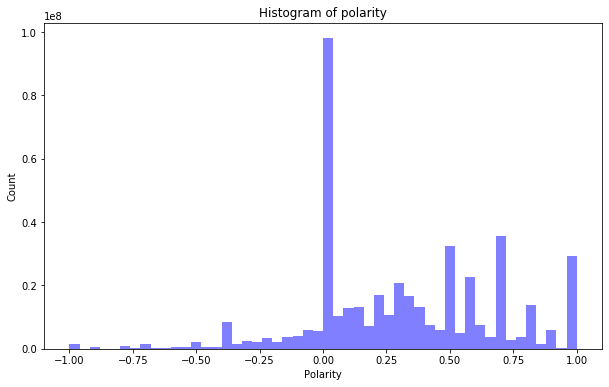

In [60]:
# What is overall distribution of review polarity? 
num_bins = 50
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(df_stats['polarity'], num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.title('Histogram of polarity')
plt.show();

In [61]:
# Let's collect our lemmas into a bag of words

http://localhost:8888/notebooks/Desktop/Thesis/09.6_Reviews_Bag_of_Words.ipynb


In [62]:
# Result is stored in:
#       'ReviewsBoW' folder
#        one file per app 
#        appId is the file name
#        file format - pickle
pd.read_pickle(''.join(['ReviewsBoW//',df_appId.loc[0]['appId'],'.pkl']))

at                                            content  \
0    2020-07-30 03:53:19  [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1...   
1    2020-07-22 21:33:52                                  [(9, 1), (11, 1)]   
2    2020-07-11 18:51:49  [(12, 1), (13, 1), (14, 1), (15, 3), (16, 1), ...   
3    2020-07-09 10:09:33  [(39, 2), (1, 2), (40, 1), (41, 2), (42, 1), (...   
4    2020-07-02 20:24:32                                          [(63, 1)]   
...                  ...                                                ...   
2455 2011-02-09 04:50:38  [(2642, 1), (195, 1), (1850, 1), (1744, 1), (3...   
2456 2011-02-08 20:02:31  [(294, 1), (365, 1), (1210, 1), (300, 1), (33,...   
2457 2011-02-06 19:58:47   [(975, 1), (203, 1), (204, 1), (9, 1), (292, 1)]   
2458 2011-02-04 20:45:55           [(327, 1), (545, 1), (14, 1), (1043, 1)]   
2459 2011-02-04 19:00:47     [(636, 1), (1, 1), (305, 1), (11, 1), (21, 1)]   

     repliedAt  score  thumbsUpCount  
0          NaT      3              6  
1          NaT      1              0  
2          NaT      4              0  
3          NaT      4              2  
4          NaT      1              0  
...        ...    ...            ...  
2455       NaT      5              2  
2456       NaT      5              2  
2457       NaT      3              0  
2458       NaT      5              2  
2459       NaT      4              1  

[2450 rows x 5 columns]

In [63]:
# Dictionary is stored in:
#        Dataset/Bow_Dictionary.pkl
bow_dict = pd.read_pickle('Dataset//BoW_Dictionary.pkl')
bow_dict = bow_dict.set_index('id')
bow_dict

word
id                      
0                   year
1                    app
2                   good
3                   last
4                 update
...                  ...
6309429            end<3
6309430  timelogger.that
6309431    structuruzing
6309432        notes(can
6309433      activities+

[6309434 rows x 1 columns]

In [64]:
# As we have now our bag of words and the dictionary stored safely, 
# let's see the most frequent words from the most rated reviews
# And separately, from the least rated reviews
def GetFreq(star):
    freq = collections.defaultdict(int)
    file_to = ''.join(['Dataset//','freq_',str(star),'_star.pkl'])

    def add_up_frequencies(x):
        freq[x[0]] += x[1]

    if not os.path.exists(file_to):
        freqList = []
        # As a first step, we'll just collect all bags from such reviews in their respective lists
        for app_Id in tqdm(list(df_appId['appId'])):
        
            file_from = ''.join(['ReviewsBoW//',app_Id,'.pkl'])
            if os.path.exists(file_from):
                scores = pd.read_pickle(file_from)
                freqList.extend(scores[scores['score']==star]['content'])
                
        # Now we need to combine all local bags and create one common dictionary of word frequencies
        [add_up_frequencies(tpl) for lst in tqdm(freqList) for tpl in lst]

        # Let's save them as well
        freqFrame = pd.DataFrame.from_dict(data=freq, orient='index')
        freqFrame.to_pickle(file_to) 
    else:
        freqFrame = pd.read_pickle(file_to)
    return freqFrame

# Here for one star ratings
osf = GetFreq(1)

# Here for five star ratings
fsf = GetFreq(5)
fsf

0
69        2799871
2        66509359
1        44709020
12       12556358
70          20678
...           ...
6309418         1
6309421         1
6309429         1
1655364         1
2779762         1

[4215378 rows x 1 columns]

In [65]:
# Let's see a wordcloud of top 1000 words from both lists
thousand_5star = sorted(dict(fsf[0]).items(), key=lambda x: x[1],reverse=True)[0:1000]

In [66]:
# Replace word id with actual word from our dictionary
tfs_freq = {bow_dict.values[t[0]][0]:t[1] for t in thousand_5star}

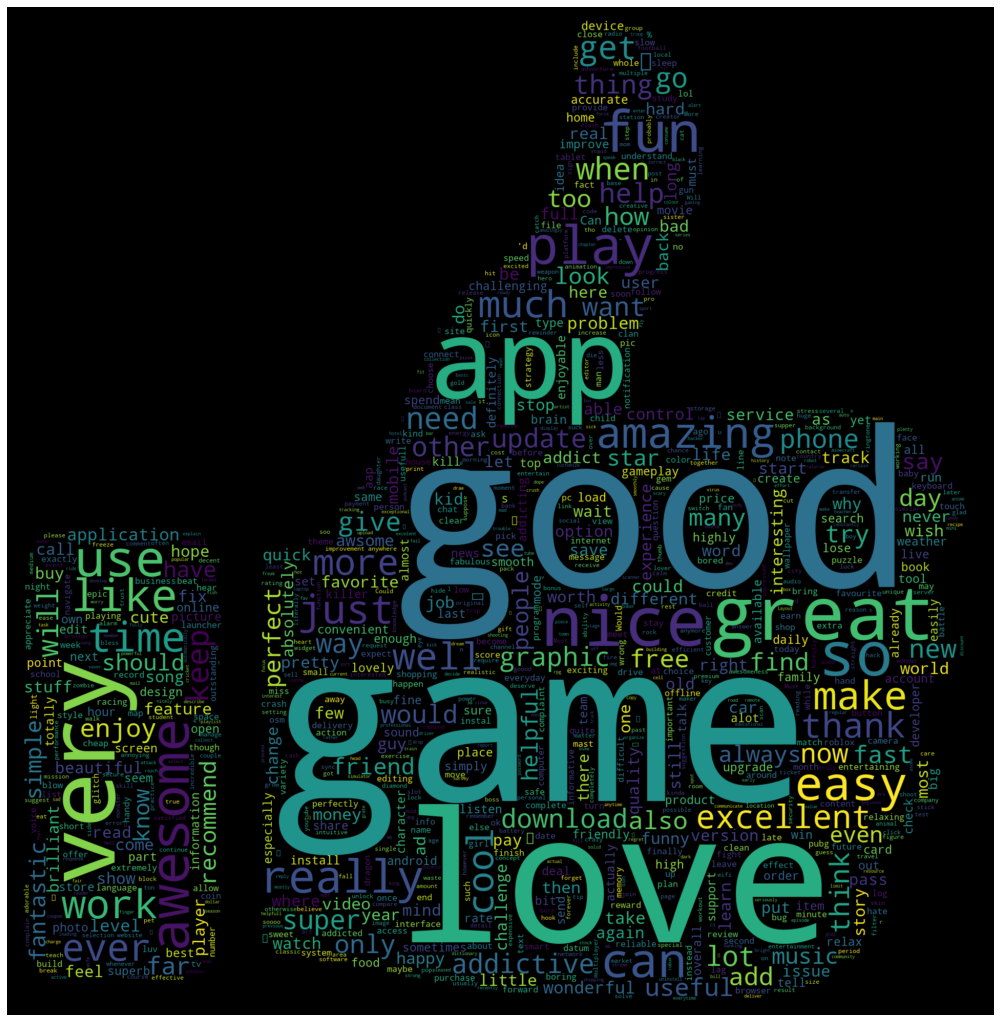

In [67]:
# This function takes in your text and your mask and generates a wordcloud. 
def generate_wordcloud(freq, mask):
    word_cloud = WordCloud(width = 512, 
                           height = 512, 
                           background_color='black',
                           max_words=1000,
                           mask=mask).generate_from_frequencies(freq)
    plt.figure(figsize=(14,14))
    plt.imshow(word_cloud,interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

# Generating wordcloud for 5 stars first
mask = np.array(Image.open("thumbUp.png"))
generate_wordcloud(tfs_freq, mask)

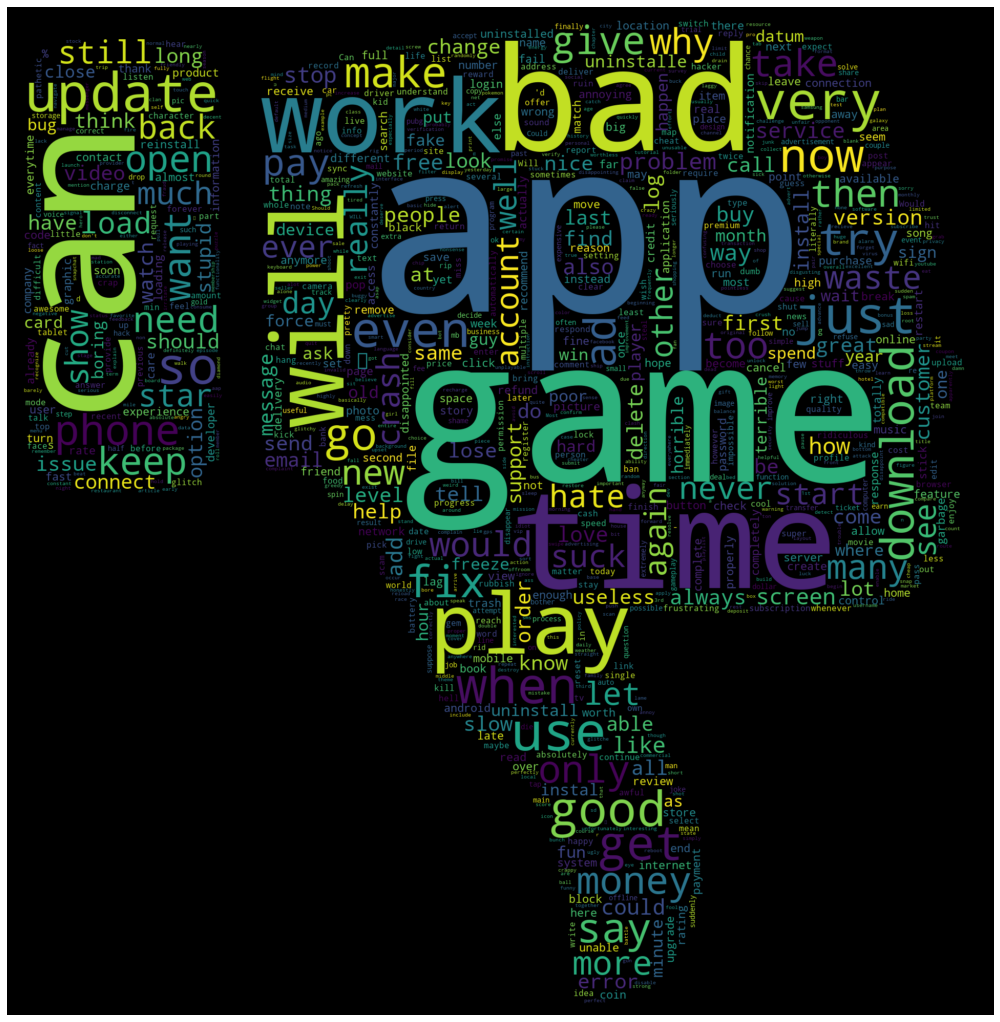

In [68]:
# Now similar wordcloud for one star ratings
osf = pd.read_pickle('Dataset//freq_1_star.pkl')
thousand_1star = sorted(dict(osf[0]).items(), key=lambda x: x[1],reverse=True)[0:1000]
tos_freq = {bow_dict.values[t[0]][0]:t[1] for t in thousand_1star}
mask = np.array(Image.open("thumbDown.png"))
generate_wordcloud(tos_freq, mask)